# Modelagem do braço estabilizador

A equipe de eletrônica e controle da Stardust, visando compreender melhor o funcionamento do protótipo  desenvolvido para mimetizar o comportamento de um drone.

A abordagem a ser utilizada é a Euler-Lagrangeana e apresenta a seguinte formulação:


$$\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{q}} - \frac{\partial \mathcal{L}}{\partial q_i} + \frac{\partial D}{\partial \dot{q_i}} = \frac{\partial W}{\partial q} $$

onde o índice i se refere ao grau de liberdade do sistema



In [1]:
from sympy import *
import sympy as sy
import sympy.physics.mechanics as me
from numpy import *
import numpy as np
from control import *
import matplotlib.pyplot as plt

## 1º passo: Coordenadas e forças generalizadas

Nesse sistema, temos apenas um grau de liberdade, que se refere à rotação que será gerada a partir do acionamento do motor do drone. Dessa forma, temos as seguintes informações:

In [2]:
q1,Q1,W,F = sy.symbols('q_1 Q_1 W F')
l,m,g = sy.symbols('l m g')
theta = me.dynamicsymbols('theta')
t = me.dynamicsymbols._t

Coordenada generalizada:

In [3]:
q = Matrix([theta])
q

Matrix([[theta(t)]])

Força generalida:

In [4]:
Q = Matrix([W])
Q

Matrix([[W]])

## 2º passo: Descrição cinemática

Modelando o braço estabilizador como se fosse um pêndulo, temos a seguinte descrição para a força aplicada na extremidade:

In [5]:
r = Matrix([-l*sy.cos(theta),-l*sy.sin(theta)])
r

Matrix([
[-l*cos(theta(t))],
[-l*sin(theta(t))]])

A fim de determinar as energias cinéticas, fará-se o cálculo da velocidade do sistema:

In [6]:
v = sy.diff(r,t)
v

Matrix([
[ l*sin(theta(t))*Derivative(theta(t), t)],
[-l*cos(theta(t))*Derivative(theta(t), t)]])

## 3º passo: Determinando as energias cinética e potencial do sistema

A fórmula da energia cinética é dada por:

$$ T = \frac{m}{2} v^{ T}v$$

In [7]:
prod_vel = v.transpose() * v
prod_vel

Matrix([[l**2*sin(theta(t))**2*Derivative(theta(t), t)**2 + l**2*cos(theta(t))**2*Derivative(theta(t), t)**2]])

Logo, a equação da energia cinética fica:

In [8]:
T = ((m/2) * prod_vel)
T

Matrix([[m*(l**2*sin(theta(t))**2*Derivative(theta(t), t)**2 + l**2*cos(theta(t))**2*Derivative(theta(t), t)**2)/2]])

In [9]:
T_simp = T.applyfunc(lambda x: simplify(x))
T_simp

Matrix([[l**2*m*Derivative(theta(t), t)**2/2]])

A energia potencial é dada por:

$$U = mgh$$

In [10]:
U = m * g * (-l*sy.cos(theta))
U

-g*l*m*cos(theta(t))

## 4º passo: Expressão para o termo de viscosidade

In [11]:
c = sy.symbols('c')

In [12]:
D = (c*sy.diff(q,t) *sy.diff(q,t))/2
D

Matrix([[c*Derivative(theta(t), t)**2/2]])

Sabendo que $\mathcal{L} = T - U $, tem-se que:

$$\mathcal{L} = T - U$$

$$\mathcal{L} = T(\dot{q}) - u(q)$$

$$\frac{d}{dt} \frac{\partial T}{\partial \dot{\theta}} + \frac{\partial U}{\partial \theta} + \frac{C \dot{\theta}}{2} = \frac{\partial FL\theta}{\partial \theta}   \hspace{1cm} (1)$$


## 5º passo: Obtendo a equação dinâmica do sistema

Resolvendo as derivadas:

- derivando o termo da energia cinética:

In [13]:
d1 = sy.diff(T_simp, sy.diff(theta,t))
d1

Matrix([[l**2*m*Derivative(theta(t), t)]])

In [14]:
d2 = sy.diff(d1, t)
d2

Matrix([[l**2*m*Derivative(theta(t), (t, 2))]])

- termo da energia potencial:

In [15]:
du = sy.diff(U,theta)
du

g*l*m*sin(theta(t))

Para pequenas oscilações, temos que $sin(\theta) \approx \theta$, logo:

In [16]:
du = Matrix([m*g*l*theta])
du

Matrix([[g*l*m*theta(t)]])

- termo da viscosidade:

In [17]:
d3 = sy.diff(D,sy.diff(theta,t))
d3

Matrix([[c*Derivative(theta(t), t)]])

- substituindo os resultados na equação 1, tem-se:

In [18]:
eq1 = d2 + du + d3
eq1

Matrix([[c*Derivative(theta(t), t) + g*l*m*theta(t) + l**2*m*Derivative(theta(t), (t, 2))]])

In [19]:
eq_alg = eq1[0]
eq_alg

c*Derivative(theta(t), t) + g*l*m*theta(t) + l**2*m*Derivative(theta(t), (t, 2))

In [20]:
eq2 = sy.Eq(eq_alg, F*l)
eq2

Eq(c*Derivative(theta(t), t) + g*l*m*theta(t) + l**2*m*Derivative(theta(t), (t, 2)), F*l)

A partir de agora, trabalharemos em função do domínio da frequência. Para isto, aplicará-se a transformada de Laplace na equação a cima.

$$(ml^2s^2 + cs + mgl)\theta(s) = F(s)l $$

In [21]:
s = sy.symbols('s')

In [22]:
frac_L = l/((m * l**2 * s**2) + (c * s) + (m * g * l))
frac_L

l/(c*s + g*l*m + l**2*m*s**2)

## 6º Passo: Realizando o controle sobre o sistema

A função acima representa a função de transferência da planta, em malha aberta, sem o controlador agindo sobre ela, e pode-se representá-la da seguinte maneira, usando a biblioteca de controle:

In [23]:
# Atribuindo valores numéricos às variáveis do sistema
m = 0.2   # massa do motor em Kg
l = 0.03  # comprimento do braço em m
c = 0.01  # constante de amortecimento N·s/m
g = 9.81  # aceleração da gravidade em m/s^2

In [24]:
G_P = tf([l],[m*l**2, c, g*l])
G_P

TransferFunction(array([0.03]), array([1.800e-04, 1.000e-02, 2.943e-01]))

Escrevendo a função do controlador PID

In [25]:
kp,kd,ki = sy.symbols('kp kd ki')

In [26]:
# Atribuindo valores às constantes de ganho:
kp = 15
kd = 0.5
ki = 350

In [27]:
G_C_1 = parallel(tf([kd],[1,0,0]),tf([ki],[1,0]),tf([kp],1))

Resolvendo a realimentação, e por conseguinte fechando a malha:

In [28]:
G1 = feedback(series(G_P,G_C_1),1)
G1

TransferFunction(array([ 0.45 , 10.5  ,  0.015,  0.   ]), array([1.800e-04, 1.000e-02, 7.443e-01, 1.050e+01, 1.500e-02, 0.000e+00]))

In [29]:
t_n = np.linspace(0,1,1000)

Definindo o setpoint:

In [30]:
u = 20*np.ones(1000)

In [31]:
t1,y1 = forced_response(G1,t_n,u)

<function matplotlib.pyplot.show(close=None, block=None)>

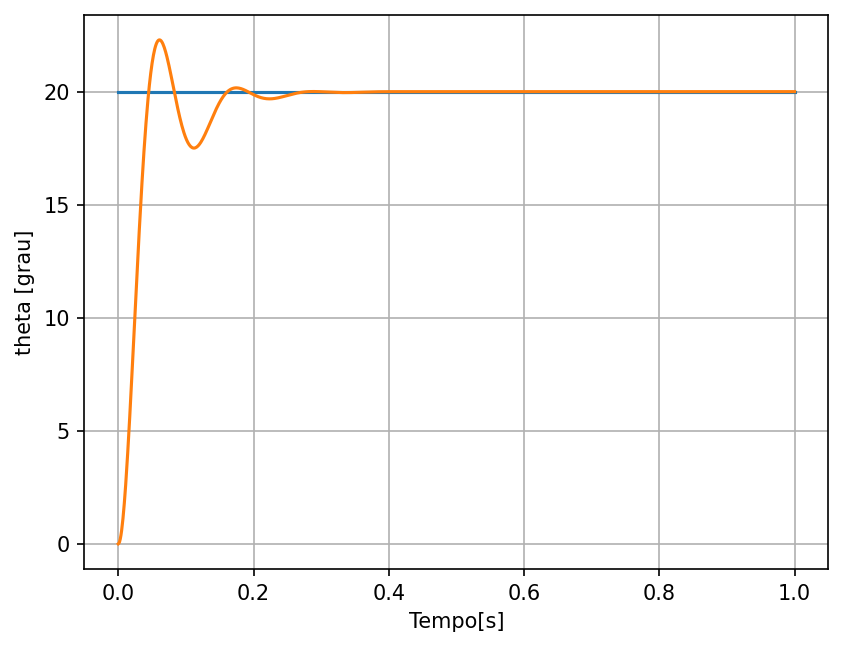

In [32]:
plt.figure(dpi = 150)
plt.plot(t_n,u)
plt.plot(t1,y1)
plt.xlabel('Tempo[s]')
plt.ylabel('theta [grau]')
plt.grid(True)
plt.show